_Titanic verileri ile oluşturduğunuz modelin performansını ölçeceksiniz._
- _Modelinizin performansı çapraz doğrulama yaparak ve farklı metrikler kullanarak değerlendirin._
- _Hiperparemetre ayarlaması yaparak en uygun parametrelere sahip modeli belirleyin._

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_validate, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('fivethirtyeight')
sns.set()

In [4]:
df = pd.read_csv('titanic_train.csv')

In [5]:
def dfCleaner(df):
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 1) #Rare
    df['Title'] = df['Title'].replace(['Mlle', 'Ms', 'Miss'], 2) #Miss
    df['Title'] = df['Title'].replace(['Mme', 'Mrs'], 3) #Mrs
    df['Title'] = df['Title'].replace('Mr', 4) #Mr
    df['Title'] = df['Title'].replace('Master', 5) #Master
    
    df['Cabin'] = df.Cabin.str.extract('([A-Z])', expand=False)
    df['Cabin'] = df.Cabin.fillna('U')
    df['Cabin'] = df.Cabin.replace({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, "U":8})
    
    df['Embarked'] = df.Embarked.fillna("C")
    df['Embarked'] = df.Embarked.replace({'C':1, 'S':2, 'Q':3})
    
    df['Family'] = df['SibSp'] + df['Parch']
    df['Age'] = df.Age.fillna(0)
    df['Sex'] = df.Sex.replace({'male':1, "female":0})

    df = df.drop(['PassengerId', 'Ticket', 'Name', 'SibSp', 'Parch'], axis=1)
    return df
df = dfCleaner(df)

In [6]:
df.head(3)

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family
0,0,3,1,22.0000,7.2500,8,2,4,1
1,1,1,0,38.0000,71.2833,3,1,3,1
2,1,3,0,26.0000,7.9250,8,2,2,0


### Çapraz Doğrulama

In [7]:
Y = df.Survived
X = df.drop('Survived', axis=1)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
model = LogisticRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)
model.score(x_test, y_test)

0.776536312849162

In [11]:
logr = LogisticRegression(solver = 'liblinear')
print(logr.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


- #### _Grid Search_

In [12]:
params = {'C': [10 ** x for x in range (-5, 5, 1)], 'penalty': ['l1', 'l2']}
grid_cv = GridSearchCV(estimator=logr, param_grid = params, cv = 10).fit(X, Y)

In [13]:
print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'C': 1, 'penalty': 'l2'}
0.8024469413233458


In [14]:
df = pd.DataFrame(grid_cv.cv_results_)
df = df[['param_penalty','param_C', 'mean_test_score']]
df = df.sort_values(by='mean_test_score', ascending = False)
df.head(5)

,param_penalty,param_C,mean_test_score
11,l2,1,0.8024
10,l1,1,0.8024
13,l2,10,0.7991
18,l1,10000,0.7979
16,l1,1000,0.7979


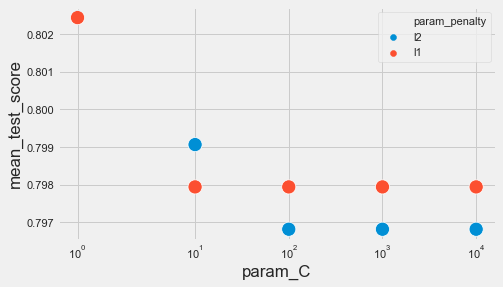

In [21]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(7,4))
sns.scatterplot(x = 'param_C', y = 'mean_test_score', hue = 'param_penalty', data = df[0:10], s=200)
plt.xscale('symlog')

- #### _Random Search_

In [22]:
random_cv = RandomizedSearchCV(estimator = logr, param_distributions = params, 
                               cv = 10, n_iter = 10, random_state = 42, scoring = 'precision').fit(X, Y)

In [23]:
print(random_cv.best_params_)
print(random_cv.best_score_)

{'penalty': 'l2', 'C': 1}
0.7692685131012438


In [24]:
randomResults = pd.DataFrame(random_cv.cv_results_)
randomResults = randomResults[['param_penalty','param_C', 'mean_test_score']]
randomResults = randomResults.sort_values(by='mean_test_score', ascending = False)
randomResults.head(5)

,param_penalty,param_C,mean_test_score
6,l2,1,0.7693
4,l1,0.1000,0.7642
8,l1,10000,0.7503
9,l1,1000,0.7503
1,l2,1000,0.7484


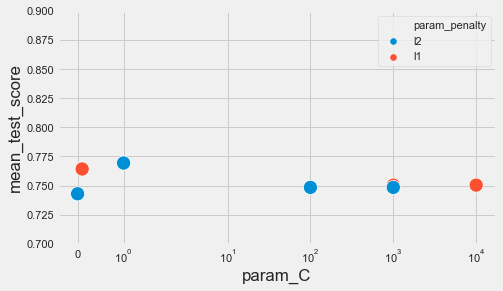

In [28]:
plt.figure(figsize=(7,4))
sns.scatterplot(x = 'param_C', y = 'mean_test_score', hue = 'param_penalty', data = randomResults, s=200)
plt.xscale('symlog')
plt.ylim((0.7,0.9))
plt.show()